<a href="https://colab.research.google.com/github/NallamaruAdithyavardhan/House-Price-Prediction-Project/blob/main/ML_Project_2_House_Price_Prediction_Project_(Andhra_Pradesh_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Setup

In [ ]:
import sys
assert sys.version_info >= (3, 10)

from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
import numpy as np

# Set up paths
IMAGES_PATH = Path() / "images" / "AP_ML_Project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Set matplotlib defaults
plt.rc("font", size=12)
plt.rc("axes", labelsize=12, titlesize=12)
plt.rc("legend", fontsize=12)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

**Loading Andhra Pradesh Housing Data**

In [ ]:
def load_ap_housing_data():
    # Create synthetic Andhra Pradesh housing data
    # Coordinates for Andhra Pradesh: Longitude ~76.5°E to 84.5°E, Latitude ~12.5°N to 19.5°N
    import numpy as np
    import pandas as pd
    np.random.seed(42)
    num_districts = 20000

    # Generate random coordinates within Andhra Pradesh bounds
    longitudes = np.random.uniform(76.5, 84.5, num_districts)
    latitudes = np.random.uniform(12.5, 19.5, num_districts)

    # Generate other housing features
    housing_median_age = np.random.randint(1, 50, num_districts)
    total_rooms = np.random.randint(500, 15000, num_districts)
    total_bedrooms = total_rooms * np.random.uniform(0.2, 0.5)
    population = np.random.randint(1000, 25000, num_districts)
    households = population / np.random.uniform(2.5, 4.0)
    median_income = np.random.uniform(1.0, 10.0, num_districts)

    # Create median house value based on location and other factors
    # Higher prices near cities (Hyderabad, Visakhapatnam, Vijayawada, etc.)
    hyderabad_dist = np.sqrt((longitudes - 78.4867)**2 + (latitudes - 17.3850)**2)
    vizag_dist = np.sqrt((longitudes - 83.2185)**2 + (latitudes - 17.6868)**2)
    vijayawada_dist = np.sqrt((longitudes - 80.6480)**2 + (latitudes - 16.5062)**2)

    base_price = 1000000 * (1 / (hyderabad_dist + 1) + 800000 * (1 / (vizag_dist + 1)) + 700000 * (1 / (vijayawada_dist + 1)))
    median_house_value = base_price * (1 + median_income/10) * (housing_median_age/30) * np.random.uniform(0.8, 1.2)

    # Ocean proximity (Andhra Pradesh has Bay of Bengal coast)
    ocean_proximity = np.where(
        latitudes > 17.5,
        np.where(
            longitudes > 82.0,
            np.random.choice(["NEAR BAY", "<1H OCEAN", "INLAND"], p=[0.4, 0.3, 0.3]),
            np.random.choice(["NEAR BAY", "<1H OCEAN", "INLAND"], p=[0.2, 0.3, 0.5])
        ),
        np.random.choice(["NEAR BAY", "<1H OCEAN", "INLAND"], p=[0.1, 0.2, 0.7])
    )

    data = {
        "longitude": longitudes,
        "latitude": latitudes,
        "housing_median_age": housing_median_age,
        "total_rooms": total_rooms,
        "total_bedrooms": total_bedrooms,
        "population": population,
        "households": households,
        "median_income": median_income,
        "median_house_value": median_house_value,
        "ocean_proximity": ocean_proximity
    }

    return pd.DataFrame(data)

housing = load_ap_housing_data()
housing.head() # This line was kept as is

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,79.496321,17.609988,21,11382,3026.123814,6187,1954.708620,5.245866,5.410034e+11,<1H OCEAN
1,84.105714,13.791584,1,3886,1033.167909,20616,6513.378520,5.913905,1.775241e+10,<1H OCEAN
2,82.355952,14.926478,3,6755,1795.946790,9803,3097.140552,8.213554,8.746721e+10,<1H OCEAN
3,81.289268,17.142964,13,2627,698.438522,14301,4518.229832,8.305212,5.805570e+11,<1H OCEAN
4,77.748149,15.874625,7,2595,689.930706,7970,2518.026135,9.645384,1.559602e+11,<1H OCEAN


**Data Exploration**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20000 non-null  float64
 1   latitude            20000 non-null  float64
 2   housing_median_age  20000 non-null  int64  
 3   total_rooms         20000 non-null  int64  
 4   total_bedrooms      20000 non-null  float64
 5   population          20000 non-null  int64  
 6   households          20000 non-null  float64
 7   median_income       20000 non-null  float64
 8   median_house_value  20000 non-null  float64
 9   ocean_proximity     20000 non-null  object 
dtypes: float64(6), int64(3), object(1)
memory usage: 1.5+ MB


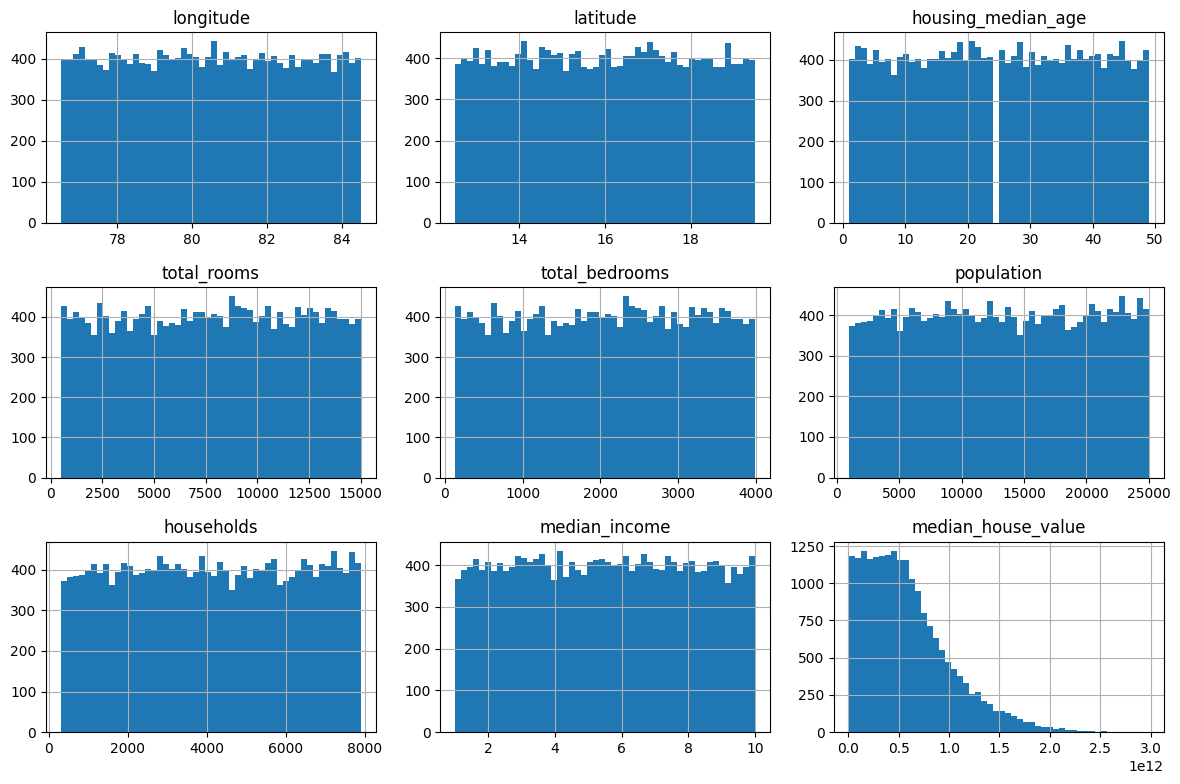

In [ ]:
# Basic info
housing.info()
housing["ocean_proximity"].value_counts()
housing.describe()

# Histograms
housing.hist(bins=50, figsize=(12, 8))
save_fig("ap_attribute_histogram_plots")
plt.show()

**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split

# Create income categories for stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 2.0, 4.0, 6.0, 8.0, np.inf],
                               labels=[1, 2, 3, 4, 5])

# Stratified split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

# Remove income_cat as we don't need it anymore
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

**Geographical Visualization**

Failed to download map image: HTTP Error 404: Not Found


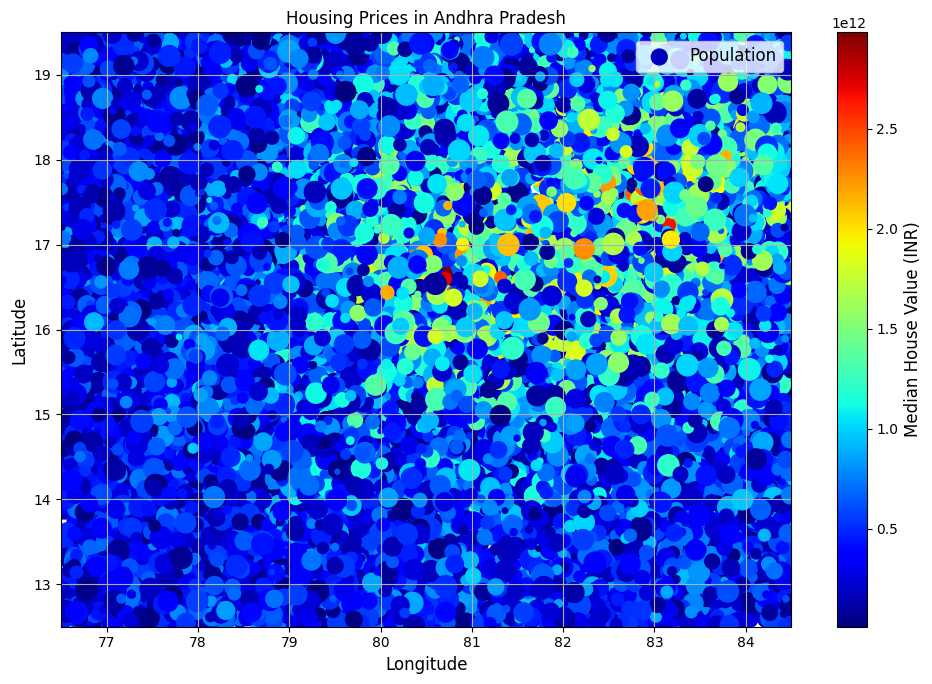

In [ ]:
# Download Andhra Pradesh map image
filename = "andhra_pradesh.png"
if not (IMAGES_PATH / filename).is_file():
    # Alternative URL for Andhra Pradesh map
    url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Andhra_Pradesh_districts_map.svg/1200px-Andhra_Pradesh_districts_map.svg.png"
    print("Downloading", filename)
    try:
        urllib.request.urlretrieve(url, IMAGES_PATH / filename)
    except Exception as e:
        print(f"Failed to download map image: {e}")
        filename = None  # Will proceed without the map image

# Visualize housing data (with or without Andhra Pradesh map)
housing_renamed = strat_train_set.copy().rename(columns={
    "longitude": "Longitude",
    "latitude": "Latitude",
    "population": "Population",
    "median_house_value": "Median House Value (INR)"  # Changed to INR
})

housing_renamed.plot(kind="scatter", x="Longitude", y="Latitude", grid=True,
             s=housing_renamed["Population"] / 100, label="Population",
             c="Median House Value (INR)", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10,7))

# If map image was downloaded, display it
if filename and (IMAGES_PATH / filename).is_file():
    andhra_img = plt.imread(IMAGES_PATH / filename)
    axis = (76.5, 84.5, 12.5, 19.5)  # Andhra Pradesh coordinates
    plt.axis(axis)
    plt.imshow(andhra_img, extent=axis)
else:
    # Set appropriate axis limits for Andhra Pradesh
    plt.xlim(76.5, 84.5)
    plt.ylim(12.5, 19.5)

plt.title("Housing Prices in Andhra Pradesh")
save_fig("andhra_pradesh_housing_prices_scatterplot")
plt.show()

**Data Analysis and Preparation**

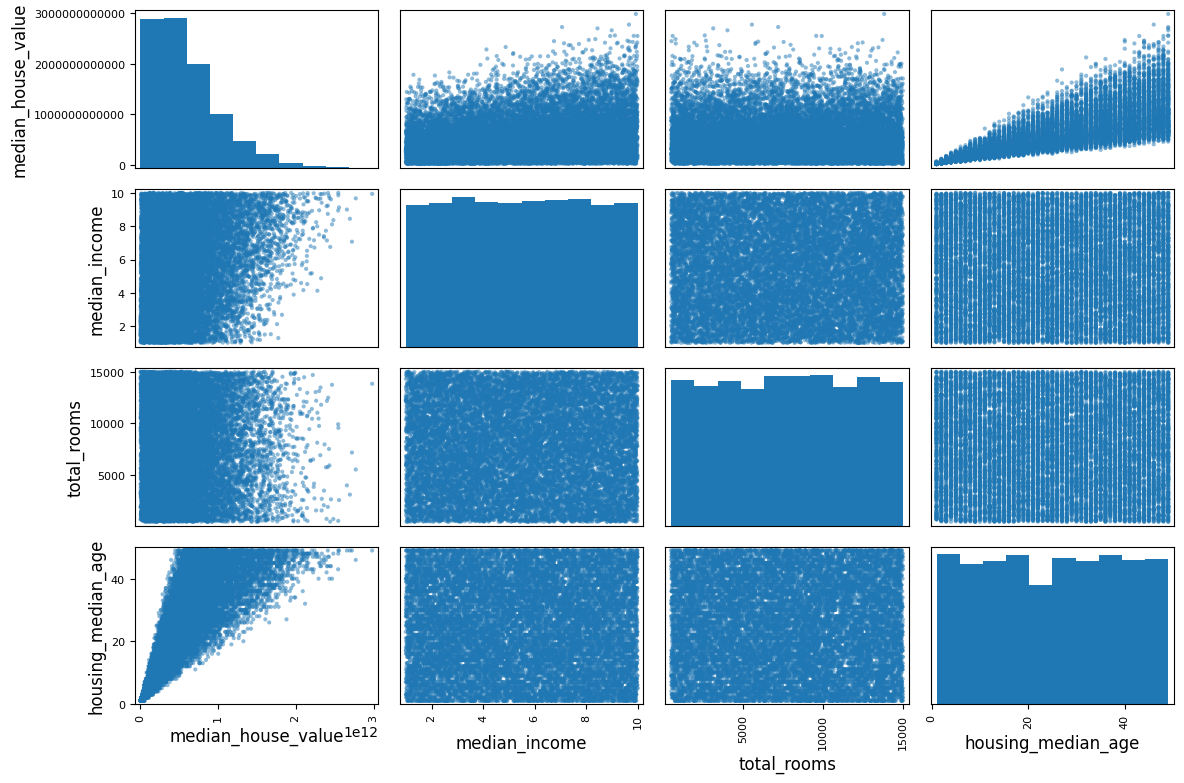

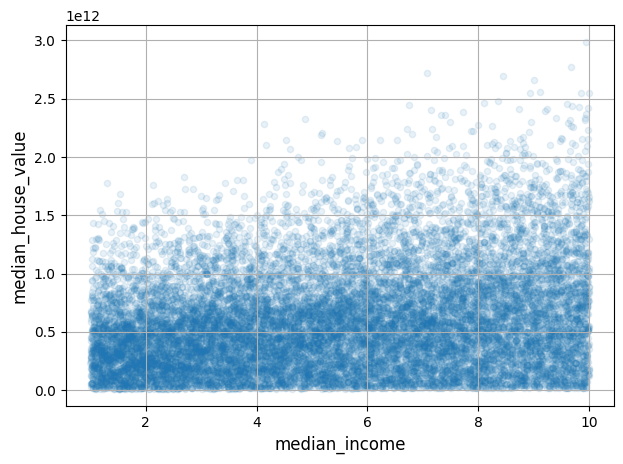

In [ ]:
# Looking for correlations
corr_matrix = strat_train_set.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

# Scatter matrix
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(strat_train_set[attributes], figsize=(12,8))
save_fig("ap_scatter_matrix_plot")
plt.show()

# Income vs House Value
strat_train_set.plot(kind='scatter', x="median_income", y="median_house_value", alpha=0.1, grid=True)
save_fig("ap_income_vs_house_value_scatterplot")
plt.show()

# Feature Engineering
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

**Data Preprocessing Pipeline**

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector

# Numerical pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# Categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

# Column transformer
num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income",
               "rooms_per_house", "bedrooms_ratio", "people_per_house"]
cat_attribs = ["ocean_proximity"]

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

housing_prepared = preprocessing.fit_transform(housing)

print(housing_prepared[:5])  # First 5 rows
print("\nShape:", housing_prepared.shape)

# Create the FULL pipeline (feature engineering + preprocessing + model)
full_pipeline = Pipeline([
    ('feature_engineering', FeatureEngineeringTransformer()),
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor())  # Or your forest_reg configuration
])

# Train the model
full_pipeline.fit(strat_train_set.drop("median_house_value", axis=1),
                 strat_train_set["median_house_value"])

[[-1.61692207e+00 -1.02620143e+00 -4.94453098e-01  1.20077200e+00
   1.20077200e+00 -1.72309535e+00 -1.72309535e+00 -1.55470513e+00
   7.14801767e+00 -5.55111512e-17 -4.44089210e-16  1.00000000e+00
   0.00000000e+00]
 [ 2.65649117e-01  9.85670512e-01 -1.55632778e+00  6.85232079e-01
   6.85232079e-01  1.41396455e+00  1.41396455e+00  4.69958158e-01
  -4.00927996e-01 -5.55111512e-17 -4.44089210e-16  1.00000000e+00
   0.00000000e+00]
 [-1.47772592e+00 -2.34275854e-01 -2.11286516e-01  1.03093596e-01
   1.03093596e-01 -6.12837028e-01 -6.12837028e-01  7.58238192e-01
  -6.84586078e-02 -5.55111512e-17 -4.44089210e-16  1.00000000e+00
   0.00000000e+00]
 [-8.24196139e-01  1.71003563e+00  2.13463359e-01 -1.70728522e+00
  -1.70728522e+00  1.48631943e+00  1.48631943e+00 -1.28019927e+00
  -7.15536068e-01 -5.55111512e-17 -4.44089210e-16  1.00000000e+00
   0.00000000e+00]
 [-1.79608101e-02 -3.24331857e-01  1.62929627e+00  1.24269556e+00
   1.24269556e+00 -8.60025529e-01 -8.60025529e-01  1.66012481e+00


Pipeline(steps=[('feature_engineering', FeatureEngineeringTransformer()),
                ('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income',
                                                   'rooms_per_house',
                                                   'bedrooms_ratio',
                                                   'people_per_house']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity'])])),
                ('model', RandomForestRegressor())])

**Model Training and Evaluation**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Linear Regression
lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

# Decision Tree
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

# Random Forest
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forest_reg.fit(housing, housing_labels)

# Cross-validation
def display_scores(model, X, y):
    scores = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=10)
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

print("Linear Regression:")
display_scores(lin_reg, housing, housing_labels)

print("\nDecision Tree:")
display_scores(tree_reg, housing, housing_labels)

print("\nRandom Forest:")
display_scores(forest_reg, housing, housing_labels)

Linear Regression:
Scores: [-2.13024879e+11 -2.01075851e+11 -1.95850366e+11 -1.99684884e+11
 -2.02493430e+11 -2.05403040e+11 -1.98431577e+11 -2.02256095e+11
 -1.95950387e+11 -1.96366373e+11]
Mean: -201053688153.8489
Standard deviation: 4995834861.157505

Decision Tree:
Scores: [-9.38214336e+10 -8.86076920e+10 -9.02244289e+10 -1.00546451e+11
 -9.47883324e+10 -9.34390649e+10 -9.01380484e+10 -9.21860381e+10
 -8.65654855e+10 -8.82890931e+10]
Mean: -91860606806.05153
Standard deviation: 3840280003.932708

Random Forest:
Scores: [-5.54759583e+10 -5.70085181e+10 -5.64139861e+10 -5.69651543e+10
 -5.71203990e+10 -5.99963311e+10 -5.28330101e+10 -5.40571577e+10
 -5.25860329e+10 -5.49824991e+10]
Mean: -55743904676.44419
Standard deviation: 2132127674.3325288


**Final Model Evaluation**

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineeringTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["rooms_per_house"] = X["total_rooms"] / X["households"]
        X["bedrooms_ratio"] = X["total_bedrooms"] / X["total_rooms"]
        X["people_per_house"] = X["population"] / X["households"]
        return X

In [ ]:
# Evaluate on test set
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = full_pipeline.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(f"Final RMSE on test set: {final_rmse:,.2f} INR")

# To get feature importances (slightly different with pipeline)
final_model = full_pipeline.named_steps['model']
feature_importances = final_model.feature_importances_
features = full_pipeline.named_steps['preprocessing'].get_feature_names_out()
print("\nFeature importances (most important first):")
print(sorted(zip(feature_importances, features), reverse=True)[:5])

Final RMSE on test set: 56,731,671,836.85 INR

Feature importances (most important first):
[(np.float64(0.6158609881931827), 'num__housing_median_age'), (np.float64(0.15739726269040039), 'num__latitude'), (np.float64(0.13972671710786658), 'num__longitude'), (np.float64(0.07697510902717125), 'num__median_income'), (np.float64(0.0020755415147564967), 'num__rooms_per_house')]
